# Treinamento e validação de modelos preditivos com AM - Trabalho 1 – INF01017 – 2021/2


## Importação das funções auxiliares e bibliotecas de aprendizado de máquina utilizados.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier



from copy import deepcopy
from itertools import count
import random
from matplotlib.pyplot import axis
from sklearn.utils import shuffle
from math import ceil
import pandas as pd

def printa(a):
    print(a)
    return

def normalizaMinMax(coluna):
    minimo = coluna.min()
    maximo = coluna.max()
    return (coluna-minimo)/(maximo-minimo)

def split_in_folds(data, k):
    max_fold_size = ceil(data["id"].count()/k)
    folds = []
    for fold_index in range(k):
        folds.append([])
        for item_index in range(max_fold_size):
            item = data.sample()
            data.drop(item.index, inplace=True)
            folds[fold_index].append(item)
            if data.empty:
                break
    return folds

def merge_folds(folds):
    result = []
    for fold in folds:
        result += fold
    return result

def fold_to_df(fold):
    df = fold[0]
    for item_index in range(1, len(fold)):
        df = pd.concat([df, fold[item_index]])
    return df

def k_fold(data, k=5):
    data_clone = deepcopy(data)
    folds = split_in_folds(data_clone, k)
    fold_sets = []
    for fold_index, fold in enumerate(folds):
        test_fold = fold_to_df(fold)
        training_folds = deepcopy(folds)
        training_folds = training_folds[:fold_index]+training_folds[fold_index+1:]
        training_folds = merge_folds(training_folds)
        training_folds = fold_to_df(training_folds)
        fold_sets.append({'training_data': training_folds, 'test_data': test_fold})
    return fold_sets

def split_validation_df(data, percentage=0.1):
    model_df = deepcopy(data)
    validation_size = int(model_df["id"].count()*percentage)
    item = model_df.sample()
    validation_df = item
    model_df.drop(item.index, inplace=True)
    for item_index in range(1, validation_size):
        item = model_df.sample()
        validation_df = pd.concat([validation_df, item])
        model_df.drop(item.index, inplace=True)
    return validation_df, model_df

def get_confusion_matrix(tp, fn, fp, tn):
    return {'tp':tp, 'fn':fn, 'fp':fp, 'tn':tn}

def get_sensitivity(confusion_matrix):
    return confusion_matrix['tp']/(confusion_matrix['tp']+confusion_matrix['fn'])

def fix_undersampling(data, feature, under_value=1,proportion=1.0):
    apenas_under = data.where(data[feature] == under_value).dropna(how='all')
    apenas_not_under = data.where(data[feature] != under_value).dropna(how='all')
    under_count = int(apenas_under["id"].count()*proportion)
    print("under count: " + str(under_count))

    print(apenas_under.count())
    print(apenas_not_under.count())
    item = apenas_not_under.sample()
    apenas_not_under.drop(item.index, inplace=True)
    dados = item
    for i in range(1, under_count):
        item = apenas_not_under.sample()
        apenas_not_under.drop(item.index, inplace=True)
        dados = pd.concat([dados,item])
    dados = pd.concat([dados, apenas_under])
    return dados

def get_confusion_matrix(results:list, expected:list):
    tp = fn = fp = tn = 0
    for index, result in enumerate(results):
        if result == 1 and expected[index] == 1:
            tp += 1
        elif result == 0 and expected[index] == 0:
            tn += 1
        elif result == 1 and expected[index] == 0:
            fp += 1
        elif result == 0 and expected[index] == 1:
            fn += 1
    return {'tp':tp, 'fn':fn, 'fp':fp, 'tn':tn}

def get_recall(confusion_matrix):
    return confusion_matrix['tp']/(confusion_matrix['tp']+confusion_matrix['fn'])

def get_precision(confusion_matrix):
    return confusion_matrix['tp']/(confusion_matrix['tp']+confusion_matrix['fp'])

def get_accuracy(confusion_matrix):
    return (confusion_matrix['tp']+confusion_matrix['tn'])/(confusion_matrix['tp']+confusion_matrix['tn']+confusion_matrix['fp']+confusion_matrix['fn'])

def get_f1_score(confusion_matrix):
    return (2*confusion_matrix['tp'])/(2*confusion_matrix['tp']+confusion_matrix['fp']+confusion_matrix['fn'])




## Importação dos dados

In [4]:
dados_entrada = pd.read_csv("healthcare-dataset-stroke-data.csv")

dados_entrada = dados_entrada.drop((dados_entrada.where(dados_entrada["gender"] == "Other").dropna()).index)
dados_entrada.count()

dados_undersampling = fix_undersampling(dados_entrada,"stroke",1,1)
dados_undersampling.count()

under count: 249
id                   249
gender               249
age                  249
hypertension         249
heart_disease        249
ever_married         249
work_type            249
Residence_type       249
avg_glucose_level    249
bmi                  209
smoking_status       249
stroke               249
dtype: int64
id                   4860
gender               4860
age                  4860
hypertension         4860
heart_disease        4860
ever_married         4860
work_type            4860
Residence_type       4860
avg_glucose_level    4860
bmi                  4699
smoking_status       4860
stroke               4860
dtype: int64


id                   498
gender               498
age                  498
hypertension         498
heart_disease        498
ever_married         498
work_type            498
Residence_type       498
avg_glucose_level    498
bmi                  451
smoking_status       498
stroke               498
dtype: int64

### Geração dos gráficos dos dados, após undersampling 

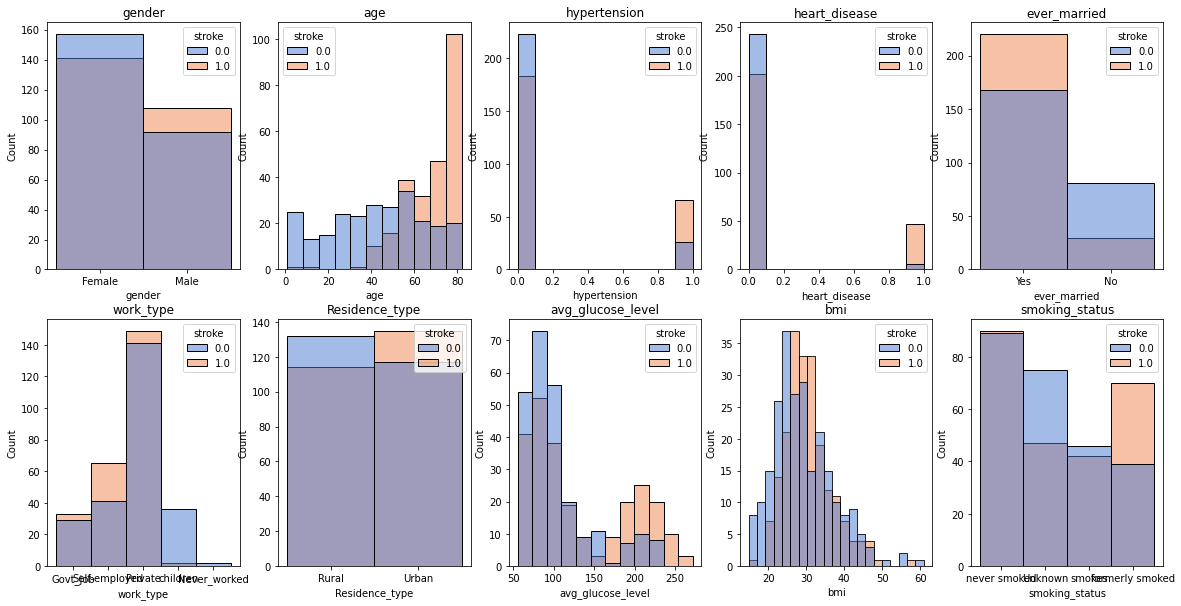

In [5]:
features = dados_undersampling.columns
lista_features = features.to_list()
lista_features.remove("id")
lista_features.remove("stroke")
i = 0
his = plt.gcf()
his.set_size_inches(20, 10)
for feature in lista_features:
    i = i+1
    plt.subplot(2,5,i)
    ax = sns.histplot(data = dados_undersampling,x = feature, hue="stroke", palette="muted").set_title(feature)

### Geração dos dummies

In [6]:


dummies = pd.get_dummies(dados_undersampling["gender"], prefix="gender-")
dados_pos_dummies = dados_undersampling.join(dummies)

dummies = pd.get_dummies(dados_undersampling["smoking_status"],prefix = "smoking_status-")
dados_pos_dummies = dados_pos_dummies.join(dummies)

dummies = pd.get_dummies(dados_undersampling["Residence_type"],prefix = "Residence_type-")
dados_pos_dummies = dados_pos_dummies.join(dummies)

dummies = pd.get_dummies(dados_undersampling["work_type"],prefix = "work_type-")
dados_pos_dummies = dados_pos_dummies.join(dummies)

dummies = pd.get_dummies(dados_undersampling["ever_married"],prefix = "ever_married-")
dados_pos_dummies = dados_pos_dummies.join(dummies)

dados_pos_dummies.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,smoking_status-_smokes,Residence_type-_Rural,Residence_type-_Urban,work_type-_Govt_job,work_type-_Never_worked,work_type-_Private,work_type-_Self-employed,work_type-_children,ever_married-_No,ever_married-_Yes
827,32352.0,Female,31.0,0.0,0.0,Yes,Govt_job,Rural,104.55,26.4,...,0,1,0,1,0,0,0,0,0,1
1961,6537.0,Female,53.0,0.0,0.0,Yes,Self-employed,Urban,84.85,24.7,...,0,0,1,0,0,0,1,0,0,1
4957,875.0,Female,34.0,0.0,0.0,No,Private,Urban,67.66,22.4,...,0,0,1,0,0,1,0,0,1,0
3323,8410.0,Female,8.0,0.0,0.0,No,children,Rural,98.90,18.8,...,0,1,0,0,0,0,0,1,1,0
4908,60426.0,Female,69.0,0.0,0.0,Yes,Self-employed,Urban,67.55,38.1,...,0,0,1,0,0,0,1,0,0,1


### Remoção do atributo bmi

In [9]:
dados_pos_dummies_dropna = dados_pos_dummies.dropna(axis=1)
dados_pos_dummies_dropna.count()

id                                 498
gender                             498
age                                498
hypertension                       498
heart_disease                      498
ever_married                       498
work_type                          498
Residence_type                     498
avg_glucose_level                  498
smoking_status                     498
stroke                             498
gender-_Female                     498
gender-_Male                       498
smoking_status-_Unknown            498
smoking_status-_formerly smoked    498
smoking_status-_never smoked       498
smoking_status-_smokes             498
Residence_type-_Rural              498
Residence_type-_Urban              498
work_type-_Govt_job                498
work_type-_Never_worked            498
work_type-_Private                 498
work_type-_Self-employed           498
work_type-_children                498
ever_married-_No                   498
ever_married-_Yes        

In [10]:
features = dados_pos_dummies_dropna.columns
lista_features = features.to_list()
lista_features.remove("id")
lista_features.remove("gender")
lista_features.remove("ever_married")
lista_features.remove("work_type")
lista_features.remove("Residence_type")
lista_features.remove("smoking_status")
lista_features.remove("stroke")
lista_features.remove('ever_married-_No')
lista_features.remove('Residence_type-_Urban')
lista_features.remove('gender-_Female')
lista_features

['age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'gender-_Male',
 'smoking_status-_Unknown',
 'smoking_status-_formerly smoked',
 'smoking_status-_never smoked',
 'smoking_status-_smokes',
 'Residence_type-_Rural',
 'work_type-_Govt_job',
 'work_type-_Never_worked',
 'work_type-_Private',
 'work_type-_Self-employed',
 'work_type-_children',
 'ever_married-_Yes']

## Normalização dos dados

In [11]:
dados_normalizados = dados_pos_dummies_dropna.copy(deep = True)

for feature in lista_features:
    dados_normalizados[feature] = normalizaMinMax(dados_normalizados[feature])

dados_normalizados.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,...,smoking_status-_smokes,Residence_type-_Rural,Residence_type-_Urban,work_type-_Govt_job,work_type-_Never_worked,work_type-_Private,work_type-_Self-employed,work_type-_children,ever_married-_No,ever_married-_Yes
827,32352.0,Female,0.372539,0.0,0.0,Yes,Govt_job,Rural,0.226402,never smoked,...,0.0,1.0,0,1.0,0.0,0.0,0.0,0.0,0,1.0
1961,6537.0,Female,0.643209,0.0,0.0,Yes,Self-employed,Urban,0.135249,never smoked,...,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0,1.0
4957,875.0,Female,0.409449,0.0,0.0,No,Private,Urban,0.055710,never smoked,...,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,1,0.0
3323,8410.0,Female,0.089567,0.0,0.0,No,children,Rural,0.200259,Unknown,...,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0,1,0.0
4908,60426.0,Female,0.840059,0.0,0.0,Yes,Self-employed,Urban,0.055201,Unknown,...,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0,1.0


## Separar o conjunto de validação

In [12]:
validacao_df, modelo_df = split_validation_df(dados_normalizados,0.1)
validacao_df.head

<bound method NDFrame.head of            id  gender       age  hypertension  heart_disease ever_married  \
71     2326.0  Female  0.815453           1.0            0.0          Yes   
1     51676.0  Female  0.741634           0.0            0.0          Yes   
177   36841.0    Male  0.950787           1.0            0.0          Yes   
182   39912.0  Female  0.384843           0.0            0.0          Yes   
136   55824.0    Male  0.926181           0.0            0.0          Yes   
2324  55982.0  Female  0.766240           0.0            0.0          Yes   
3671  37038.0    Male  0.175689           0.0            0.0           No   
242   45535.0    Male  0.827756           0.0            0.0          Yes   
133   31563.0  Female  0.458661           0.0            0.0          Yes   
2978   2218.0    Male  0.507874           0.0            0.0          Yes   
1655  29385.0  Female  0.680118           0.0            0.0          Yes   
85    32399.0    Male  0.655512           0.0 

## K-Nearest Neighbors Classifier

   Acuracia  Precisão    Recall  F1-score
0  0.666667  0.607143  0.809524  0.693878
1  0.511111  0.576923  0.576923  0.576923
2  0.733333  0.818182  0.692308  0.750000
3  0.600000  0.583333  0.636364  0.608696
4  0.488889  0.391304  0.500000  0.439024
5  0.688889  0.647059  0.578947  0.611111
6  0.622222  0.636364  0.608696  0.622222
7  0.777778  0.833333  0.681818  0.750000
8  0.600000  0.555556  0.714286  0.625000
9  0.613636  0.736842  0.538462  0.622222


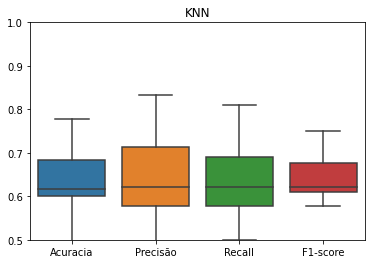

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

TOTAL_FOLDS = 10
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
acuracia = []
precisao = []
recall = []
f1 = []

matriz_confusao = []
for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    knn.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    ypredito = knn.predict(Xteste)
    matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
    acuracia.append(get_accuracy(matriz_confusao))
    recall.append(get_recall(matriz_confusao))
    precisao.append(get_precision(matriz_confusao))
    f1.append(get_f1_score(matriz_confusao))



resultados = pd.DataFrame({ 
    "Acuracia": acuracia,
    "Precisão": precisao,
    "Recall": recall,
    "F1-score": f1
})


print(resultados)
sns.boxplot(data=resultados).set(title='KNN',ylim=(0.5, 1)) # RUN PLOT   
plt.show()


## Árvores de decisão

   Acuracia  Precisão    Recall  F1-score
0  0.777778  0.809524  0.739130  0.772727
1  0.733333  0.769231  0.769231  0.769231
2  0.688889  0.700000  0.636364  0.666667
3  0.755556  0.680000  0.850000  0.755556
4  0.777778  0.692308  0.900000  0.782609
5  0.733333  0.653846  0.850000  0.739130
6  0.711111  0.761905  0.666667  0.711111
7  0.688889  0.772727  0.653846  0.708333
8  0.755556  0.842105  0.666667  0.744186
9  0.772727  0.894737  0.680000  0.772727


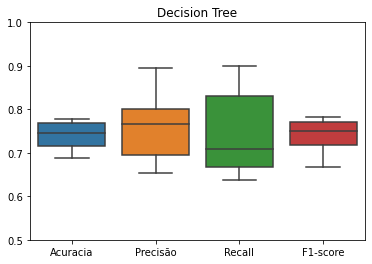

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dts = DecisionTreeClassifier(min_samples_leaf = 8)

TOTAL_FOLDS = 10
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
acuracia = []
precisao = []
recall = []
f1 = []

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    dts.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    ypredito = dts.predict(Xteste)
    matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
    acuracia.append(get_accuracy(matriz_confusao))
    recall.append(get_recall(matriz_confusao))
    precisao.append(get_precision(matriz_confusao))
    f1.append(get_f1_score(matriz_confusao))



resultados = pd.DataFrame({ 
    "Acuracia": acuracia,
    "Precisão": precisao,
    "Recall": recall,
    "F1-score": f1
})
print(resultados)
sns.boxplot(data=resultados).set(title='Decision Tree',ylim=(0.5, 1)) # RUN PLOT   
plt.show()

## Floresta de decisão

   Acuracia  Precisão    Recall  F1-score
0  0.706667  0.666667  0.742857  0.702703
1  0.746667  0.725000  0.783784  0.753247
2  0.746667  0.714286  0.875000  0.786517
3  0.866667  0.871795  0.871795  0.871795
4  0.840000  0.868421  0.825000  0.846154
5  0.716216  0.704545  0.794872  0.746988


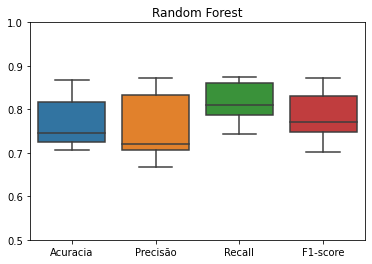

In [ ]:
rfc = RandomForestClassifier(n_estimators = 150, min_samples_split = 6, max_depth = 8)

TOTAL_FOLDS = 6
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
acuracia = []
precisao = []
recall = []
f1 = []

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    rfc.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    ypredito = rfc.predict(Xteste)
    matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
    acuracia.append(get_accuracy(matriz_confusao))
    recall.append(get_recall(matriz_confusao))
    precisao.append(get_precision(matriz_confusao))
    f1.append(get_f1_score(matriz_confusao))



resultados = pd.DataFrame({ 
    "Acuracia": acuracia,
    "Precisão": precisao,
    "Recall": recall,
    "F1-score": f1
})

print(resultados)
sns.boxplot(data=resultados).set(title='Random Forest',ylim=(0.5, 1)) # RUN PLOT   
plt.show()

## Adaptive Boosting

   Acuracia  Precisão    Recall  F1-score
0  0.787611  0.806452  0.806452  0.806452
1  0.778761  0.762712  0.803571  0.782609
2  0.716814  0.636364  0.840000  0.724138
3  0.745455  0.774194  0.774194  0.774194


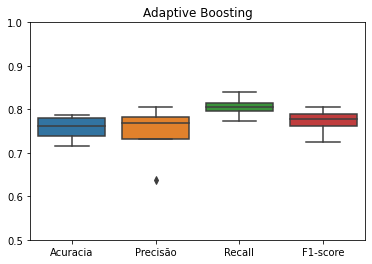

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier()

TOTAL_FOLDS = 4
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
acuracia = []
precisao = []
recall = []
f1 = []

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    adb.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    ypredito = adb.predict(Xteste)
    matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
    acuracia.append(get_accuracy(matriz_confusao))
    recall.append(get_recall(matriz_confusao))
    precisao.append(get_precision(matriz_confusao))
    f1.append(get_f1_score(matriz_confusao))



resultados = pd.DataFrame({ 
    "Acuracia": acuracia,
    "Precisão": precisao,
    "Recall": recall,
    "F1-score": f1
})
print(resultados)
sns.boxplot(data=resultados).set(title='Adaptive Boosting',ylim=(0.5, 1)) # RUN PLOT   
plt.show()

## Rede Neural

   Acuracia  Precisão    Recall  F1-score
0  0.800000  0.708333  0.894737  0.790698
1  0.644444  0.700000  0.583333  0.636364
2  0.777778  0.724138  0.913043  0.807692
3  0.800000  0.708333  0.894737  0.790698
4  0.866667  0.894737  0.809524  0.850000
5  0.733333  0.590909  0.812500  0.684211
6  0.800000  0.724138  0.954545  0.823529
7  0.800000  0.791667  0.826087  0.808511
8  0.888889  0.846154  0.956522  0.897959
9  0.840909  0.965517  0.823529  0.888889


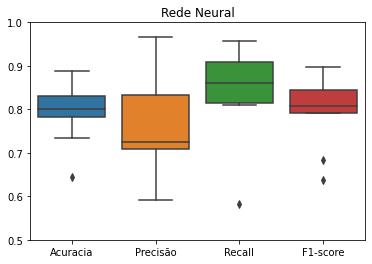

In [ ]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(warm_start=True, max_iter = 1000,hidden_layer_sizes=(40,2))

TOTAL_FOLDS = 10
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
acuracia = []
precisao = []
recall = []
f1 = []

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    MLP.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    ypredito = MLP.predict(Xteste)
    matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
    acuracia.append(get_accuracy(matriz_confusao))
    recall.append(get_recall(matriz_confusao))
    precisao.append(get_precision(matriz_confusao))
    f1.append(get_f1_score(matriz_confusao))



resultados = pd.DataFrame({ 
    "Acuracia": acuracia,
    "Precisão": precisao,
    "Recall": recall,
    "F1-score": f1
})
print(resultados)
sns.boxplot(data=resultados).set(title='Rede Neural',ylim=(0.5, 1)) # RUN PLOT   
plt.show()


## Gradient Boosting

   Acuracia  Precisão    Recall  F1-score
0  0.733333  0.590909  0.812500  0.684211
1  0.733333  0.814815  0.758621  0.785714
2  0.688889  0.739130  0.680000  0.708333
3  0.800000  0.826087  0.791667  0.808511
4  0.666667  0.576923  0.789474  0.666667
5  0.777778  0.750000  0.818182  0.782609
6  0.844444  0.760000  0.950000  0.844444
7  0.800000  0.800000  0.833333  0.816327
8  0.755556  0.750000  0.782609  0.765957
9  0.863636  0.900000  0.818182  0.857143


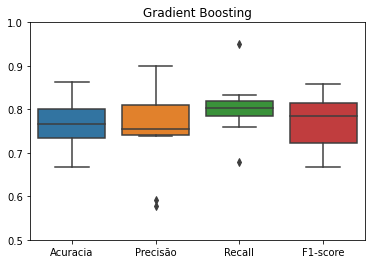

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

GDB = GradientBoostingClassifier()

TOTAL_FOLDS = 10
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
acuracia = []
precisao = []
recall = []
f1 = []

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    GDB.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    ypredito = GDB.predict(Xteste)
    matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
    acuracia.append(get_accuracy(matriz_confusao))
    recall.append(get_recall(matriz_confusao))
    precisao.append(get_precision(matriz_confusao))
    f1.append(get_f1_score(matriz_confusao))



resultados = pd.DataFrame({ 
    "Acuracia": acuracia,
    "Precisão": precisao,
    "Recall": recall,
    "F1-score": f1
})
print(resultados)
sns.boxplot(data=resultados).set(title='Gradient Boosting',ylim=(0.5, 1)) # RUN PLOT   
plt.show()

## Validação dos resultados encontrados

In [ ]:
MLP = MLPClassifier(max_iter = 5000,hidden_layer_sizes=(40,2))
KNN = KNeighborsClassifier(n_neighbors=5)
DTC = DecisionTreeClassifier(min_samples_leaf = 8)
RFC = RandomForestClassifier(n_estimators = 150, min_samples_split = 6, max_depth = 8)
ADB = AdaBoostClassifier()
GBC = GradientBoostingClassifier(n_estimators = 200)

Xtreino = modelo_df[lista_features]
ytreino = modelo_df["stroke"]

KNN.fit(Xtreino,ytreino)
DTC.fit(Xtreino,ytreino)
RFC.fit(Xtreino,ytreino)
ADB.fit(Xtreino,ytreino)
GBC.fit(Xtreino,ytreino)
MLP.fit(Xtreino,ytreino)

Xteste = validacao_df[lista_features]
yteste = validacao_df["stroke"]

ypredito = KNN.predict(Xteste)
matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
acuracia = get_accuracy(matriz_confusao)
recall = get_recall(matriz_confusao)
precisao = get_precision(matriz_confusao)
f1 = get_f1_score(matriz_confusao)
print("Acuracia média knn: " + (str(acuracia)))
print("Precisão médio knn: " + (str(precisao)))
print("Recall médio knn: " + (str(recall)))
print("F1 médio knn: " + (str(f1)))
print("--------------------------")

ypredito = DTC.predict(Xteste)
matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
acuracia = get_accuracy(matriz_confusao)
recall = get_recall(matriz_confusao)
precisao = get_precision(matriz_confusao)
f1 = get_f1_score(matriz_confusao)
print("Acuracia média decision trees: " + (str(acuracia)))
print("Precisão médio decision trees: " + (str(precisao)))
print("Recall médio decision trees: " + (str(recall)))
print("F1 médio decision trees: " + (str(f1)))
print("--------------------------")

ypredito = RFC.predict(Xteste)
matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
acuracia = get_accuracy(matriz_confusao)
recall = get_recall(matriz_confusao)
precisao = get_precision(matriz_confusao)
f1 = get_f1_score(matriz_confusao)
print("Acuracia média random forests: " + (str(acuracia)))
print("Precisão médio random forests: " + (str(precisao)))
print("Recall médio random forests: " + (str(recall)))
print("F1 médio random forests: " + (str(f1)))
print("--------------------------")

ypredito = ADB.predict(Xteste)
matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
acuracia = get_accuracy(matriz_confusao)
recall = get_recall(matriz_confusao)
precisao = get_precision(matriz_confusao)
f1 = get_f1_score(matriz_confusao)
print("Acuracia média adaboost: " + (str(acuracia)))
print("Precisão médio adaboost: " + (str(precisao)))
print("Recall médio adaboost: " + (str(recall)))
print("F1 médio adaboost: " + (str(f1)))
print("--------------------------")

ypredito = GBC.predict(Xteste)
matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
acuracia = get_accuracy(matriz_confusao)
recall = get_recall(matriz_confusao)
precisao = get_precision(matriz_confusao)
f1 = get_f1_score(matriz_confusao)
print("Acuracia média gradient boost: " + (str(acuracia)))
print("Precisão médio gradient boost: " + (str(precisao)))
print("Recall médio gradient boost: " + (str(recall)))
print("F1 médio gradient boost: " + (str(f1)))
print("--------------------------")

ypredito = MLP.predict(Xteste)
matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
acuracia = get_accuracy(matriz_confusao)
recall = get_recall(matriz_confusao)
precisao = get_precision(matriz_confusao)
f1 = get_f1_score(matriz_confusao)

print("Acuracia média rede neural: " + (str(acuracia)))
print("Precisão médio rede neural: " + (str(precisao)))
print("Recall médio rede neural: " + (str(recall)))
print("F1 médio rede neural: " + (str(f1)))
print("--------------------------")

Acuracia média knn: 0.6938775510204082
Precisão médio knn: 0.7777777777777778
Recall médio knn: 0.56
F1 médio knn: 0.6511627906976745
--------------------------
Acuracia média decision trees: 0.7551020408163265
Precisão médio decision trees: 0.782608695652174
Recall médio decision trees: 0.72
F1 médio decision trees: 0.75
--------------------------
Acuracia média random forests: 0.7755102040816326
Precisão médio random forests: 0.8181818181818182
Recall médio random forests: 0.72
F1 médio random forests: 0.7659574468085106
--------------------------
Acuracia média adaboost: 0.7142857142857143
Precisão médio adaboost: 0.8235294117647058
Recall médio adaboost: 0.56
F1 médio adaboost: 0.6666666666666666
--------------------------
Acuracia média gradient boost: 0.7755102040816326
Precisão médio gradient boost: 0.85
Recall médio gradient boost: 0.68
F1 médio gradient boost: 0.7555555555555555
--------------------------
Acuracia média rede neural: 0.7959183673469388
Precisão médio rede neura